Non-Notebook scripts used for input
* compute_agg_proportionality.r
* compute_bulk_proportionality.r
* run_proportionality.sh (runs compute agg)

## Imports

In [21]:
import numpy as np
import pandas as pd
import gc
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

from scipy import spatial, cluster
import pymn

import joypy

In [22]:
from rank import rank
from egad import run_egad

In [23]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [24]:
import sys
sys.path.append('/home/bharris/biccn_paper/scripts/')

import load_pearson_networks

In [25]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from move_seaborn_legend import move_legend

## Functions

In [14]:
def create_empty_network(genes=genes):
    return np.zeros([genes.shape[0], genes.shape[0]])

In [16]:
def aggregate_networks(datasets, level, genes=genes):
    nws_path = '/home/bharris/biccn_paper/data/networks/proportionality/proportionality_nw_'
    agg_nw = create_empty_network()
    for dataset in datasets:
        if 'macosko' in dataset:
            dataset = 'macosko'
        nw = pd.read_csv(f'{nws_path}{dataset}_{level}.csv.gz', index_col=0)
        agg_nw += nw.values
        del nw
        gc.collect()
    rank(agg_nw)
    return pd.DataFrame(agg_nw, index=genes, columns=genes)

## Load data

In [28]:
bulk_agg_nw = bulk_agg_nw = pd.read_csv(
    '/home/bharris/biccn_paper/data/networks/proportionality/bulk_agg_nw.csv.gz',
    index_col=0)

In [29]:
dataset_dict = pd.read_csv(
    '/home/bharris/biccn_paper/data/dataset_dict_biccn_sets_7.csv',
    index_col=0).to_dict()

In [30]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_slim = np.genfromtxt('/home/bharris/GO_data/aug4.GOslim', dtype=str)

go_mouse_slim = go_mouse[np.intersect1d(go_mouse.columns, go_slim)]

In [31]:
genes = np.genfromtxt(
    '/home/bharris/biccn_paper/data/highly_expressed_7_datasets_75k.csv',
    dtype=str)

In [32]:
pearson_nws = load_pearson_networks.load_all_networks()

2020-12-28 12:41:52,669 - zeng_10x_cell
2020-12-28 12:42:17,514 - zeng_10x_nuc
2020-12-28 12:42:43,179 - zeng_smart_cell
2020-12-28 12:43:07,503 - zeng_smart_nuc
2020-12-28 12:43:31,521 - zeng_10x_cell_v3
2020-12-28 12:43:54,248 - zeng_10x_nuc_v3
2020-12-28 12:44:17,998 - macosko_10x_nuc_v3


## Analyze GO

In [33]:
agg_class_label = aggregate_networks(dataset_dict.keys(), 'class_label')
agg_subclass_label = aggregate_networks(dataset_dict.keys(), 'subclass_label')
agg_joint_cluster_label = aggregate_networks(dataset_dict.keys(),
                                             'joint_cluster_label')

In [34]:
cl = run_egad(go_mouse, agg_class_label)
cl['level'] = 'Class Label'
scl = run_egad(go_mouse, agg_subclass_label)
scl['level'] = 'Subclass Label'
jcl = run_egad(go_mouse, agg_joint_cluster_label)
jcl['level'] = 'Cluster Label'
bl = run_egad(go_mouse, bulk_agg_nw)
bl['level'] = 'bulk'

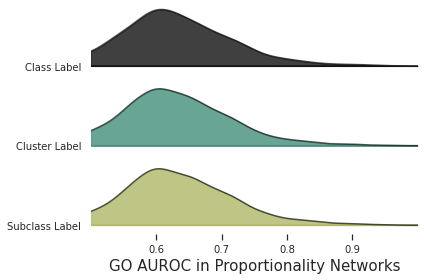

In [60]:
joypy.joyplot(pd.concat([cl, scl, jcl])[['level', 'AUC']],
              by='level',
              colormap=plt.cm.gist_earth,
              alpha=.75,
              x_range=[.5, 1])
plt.xlabel('GO AUROC in Proportionality Networks')
plt.tight_layout()
plt.savefig(
    '/home/bharris/biccn_paper/figures/resub/proportionality_subclass_GO.pdf',
    transparent=True)

In [36]:
pd.concat([cl, scl, jcl, bl]).groupby('level').mean().rename({
    'joint_cluster_label': 'cluster_label'
}).iloc[[0, 2, 1]]

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value
level,,,,
Class Label,0.625030,2030.745124,0.446899,0.034714
Subclass Label,0.629120,2026.775284,0.445523,0.032030
Cluster Label,0.624992,2027.252932,0.449323,0.033785


## Analzye Markers

In [38]:
markers = pd.read_csv('/home/bharris/biccn_paper/data/stephan_marker_nw.csv',
                      index_col=0)
markers.drop(columns=['Glutamatergic', 'Non.Neuronal', 'GABAergic'],
             inplace=True)

In [39]:
bm = run_egad(markers, bulk_agg_nw)
bm['level'] = 'Bulk'

cm = run_egad(markers, agg_class_label)
cm['level'] = 'Class Label'

sm = run_egad(markers, agg_subclass_label)
sm['level'] = 'Subclass Label'

scm = run_egad(markers, agg_joint_cluster_label)
scm['level'] = 'Cluster Label'

combined_marker_performance = pd.concat([bm, cm, sm, scm])

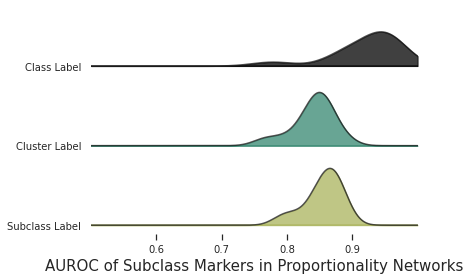

In [61]:
joypy.joyplot(
    combined_marker_performance.loc[combined_marker_performance.level != 'Bulk',
                                    ['level', 'AUC']],
    by='level',
    colormap=plt.cm.gist_earth,
    alpha=.75,
    x_range=[.5, 1])
plt.xlabel('AUROC of Subclass Markers in Proportionality Networks')
plt.tight_layout()
plt.savefig(
    '/home/bharris/biccn_paper/figures/resub/proportionality_subclass.pdf',
    transparent=True)

In [63]:
combined_marker_performance.groupby('level').mean()

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value
level,,,,
Bulk,0.862208,1450.307009,0.171069,8.102442e-30
Class Label,0.920923,1847.037079,0.241754,3.695319e-23
Cluster Label,0.840422,1891.463336,0.303756,1.319382e-21
Subclass Label,0.854898,1847.524785,0.250808,2.922753e-25
